# Import 2 file .pkl đã

In [ ]:
import os
import numpy as np
import pandas as pd

In [ ]:
import pickle
with open('/content/X.pkl', 'rb') as f:
  X = pickle.load(f)
with open('/content/Y.pkl', 'rb') as f:
  Y = pickle.load(f)

In [ ]:
from sklearn.model_selection import train_test_split

xtrain, xtest, ytrain, ytest = train_test_split(X, Y, test_size=0.2)


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
class TemporalBlock(tf.keras.layers.Layer):
    def __init__(self, n_inputs, n_outputs, kernel_size, dilation_rate, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()

        self.conv1 = layers.Conv1D(filters=n_outputs, kernel_size=kernel_size,
                                   padding=padding, dilation_rate=dilation_rate,
                                   kernel_initializer='he_normal')
        self.bn1 = layers.BatchNormalization()
        self.relu1 = layers.ReLU()
        self.dropout1 = layers.Dropout(dropout)

        self.conv2 = layers.Conv1D(filters=n_outputs, kernel_size=kernel_size,
                                   padding=padding, dilation_rate=dilation_rate,
                                   kernel_initializer='he_normal')
        self.bn2 = layers.BatchNormalization()
        self.relu2 = layers.ReLU()
        self.dropout2 = layers.Dropout(dropout)

        self.downsample = None
        if n_inputs != n_outputs:
            self.downsample = layers.Conv1D(n_outputs, kernel_size=1, padding="same")

        self.final_relu = layers.ReLU()

    def call(self, x, training=None):
        out = self.conv1(x)
        # out = self.bn1(out, training=training)
        out = self.relu1(out)
        out = self.dropout1(out, training=training)

        out = self.conv2(out)
        # out = self.bn2(out, training=training)
        out = self.relu2(out)
        out = self.dropout2(out, training=training)

        res = x if self.downsample is None else self.downsample(x)
        out = tf.keras.layers.Add()([out, res])
        return self.final_relu(out)

class TemporalConvNet(tf.keras.layers.Layer):
    def __init__(self, num_inputs, num_channels, kernel_size, dropout=0.3):
        super(TemporalConvNet, self).__init__()
        layers_list = []
        num_levels = len(num_channels)

        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i - 1]
            out_channels = num_channels[i]
            layers_list.append(
                TemporalBlock(in_channels, out_channels, kernel_size, dilation_size, padding="causal", dropout=dropout)
            )

        self.network = tf.keras.Sequential(layers_list)

    def call(self, x, training=None):
        return self.network(x, training=training)

def build_tcn_model(input_shape=(32, 40, 2), num_classes=1):
    inputs = tf.keras.Input(shape=input_shape)

    # Reshape để chuyển (32, 40, 2) -> (32, 80)
    x = layers.Reshape((input_shape[0], input_shape[1] * input_shape[2]))(inputs)

    # Gọi TemporalConvNet
    x = TemporalConvNet(num_inputs=80, num_channels=[128, 256, 512], kernel_size=3)(x)

    # Global Pooling & Fully Connected
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(num_classes, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer= Adam(learning_rate = 0.0001),
        loss='binary_crossentropy',
        metrics=['accuracy', 'precision', 'recall']
    )
    return model

# Kiểm tra mô hình
model = build_tcn_model()
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'temporal_block_45', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'temporal_block_46', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'temporal_block_47', however t

Model: "functional_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_26 (InputLayer)     │ (None, 32, 40, 2)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_12 (Reshape)            │ (None, 32, 80)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ temporal_conv_net_15            │ (None, 32, 512)        │     1,731,200 │
│ (TemporalConvNet)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_15     │ (None, 512)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,764,097 (6.73 MB)

 Trainable params: 1,764,097 (6.73 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# xtrain = xtrain.reshape((-1, 32, 80))
# xtest = xtest.reshape((-1, 32, 80))

In [ ]:
xtrain[0].shape

(32, 40, 2)

In [ ]:
history = model.fit(xtrain, ytrain, batch_size= 64, epochs= 200, validation_data= (xtest, ytest))

Epoch 1/200
229/229 ━━━━━━━━━━━━━━━━━━━━ 46s 57ms/step - accuracy: 0.5090 - loss: 0.7032 - precision: 0.5010 - recall: 0.4800 - val_accuracy: 0.5352 - val_loss: 0.6850 - val_precision: 0.5465 - val_recall: 0.1614
Epoch 2/200
229/229 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.5386 - loss: 0.6887 - precision: 0.5289 - recall: 0.4809 - val_accuracy: 0.5475 - val_loss: 0.6851 - val_precision: 0.5176 - val_recall: 0.7825
Epoch 3/200
229/229 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.5302 - loss: 0.6855 - precision: 0.5211 - recall: 0.5998 - val_accuracy: 0.5360 - val_loss: 0.6841 - val_precision: 0.5955 - val_recall: 0.0910
Epoch 4/200
229/229 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.5355 - loss: 0.6820 - precision: 0.5274 - recall: 0.5107 - val_accuracy: 0.5368 - val_loss: 0.6771 - val_precision: 0.5157 - val_recall: 0.5083
Epoch 5/200
229/229 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.5474 - loss: 0.6796 - precision: 0.5373 - recall: 0.6937 - val_accuracy: 0.5518 - v

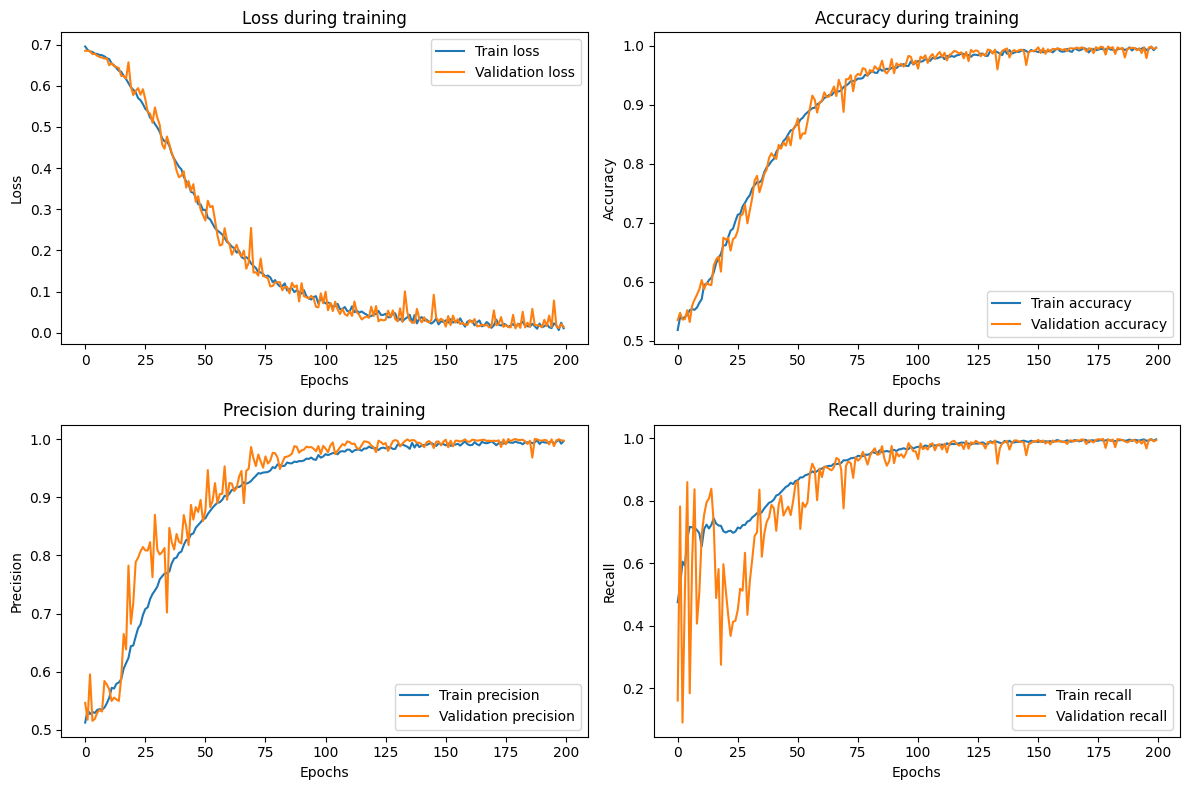

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    metrics = ['loss', 'accuracy', 'precision', 'recall']
    titles = ['Loss', 'Accuracy', 'Precision', 'Recall']
    ylabel = ['Loss', 'Accuracy', 'Precision', 'Recall']

    plt.figure(figsize=(12, 8))
    for i, metric in enumerate(metrics):
        plt.subplot(2, 2, i + 1)
        plt.plot(history.history[metric], label=f'Train {metric}')
        plt.plot(history.history[f'val_{metric}'], label=f'Validation {metric}')
        plt.xlabel('Epochs')
        plt.ylabel(ylabel[i])
        plt.legend()
        plt.title(f'{titles[i]} during training')

    plt.tight_layout()
    # plt.savefig("/content/drive/MyDrive/training_metrics.png", dpi=300)  # Lưu với độ phân giải cao
    plt.show()
plot_training_history(history)

In [ ]:
model.save("tcn.keras")

In [ ]:
x_t = xtrain[0].reshape((1, 32, 40, 2))
y_t = ytrain[0]
x_t, y_t

(array([[[[0.48014574, 0.07299799],
          [0.33416686, 0.        ],
          [0.18759219, 0.07653975],
          ...,
          [0.6033946 , 0.49680046],
          [0.71475934, 0.483477  ],
          [0.86765904, 0.40313791]],
 
         [[0.47963022, 0.07508125],
          [0.3336162 , 0.        ],
          [0.18742458, 0.07510577],
          ...,
          [0.59979775, 0.5057541 ],
          [0.71156251, 0.4953731 ],
          [0.86651037, 0.41660233]],
 
         [[0.47960536, 0.07463746],
          [0.33356234, 0.        ],
          [0.18764661, 0.07384335],
          ...,
          [0.60011039, 0.5045187 ],
          [0.7116279 , 0.49219784],
          [0.86577271, 0.40541309]],
 
         ...,
 
         [[0.44034849, 0.04266049],
          [0.29376213, 0.        ],
          [0.15737145, 0.05893041],
          ...,
          [0.58707626, 0.63460896],
          [0.69981562, 0.59010295],
          [0.85540849, 0.28773021]],
 
         [[0.44192427, 0.0409606 ],
          [0

In [ ]:
model.predict(test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 958ms/step


array([[0.9997913]], dtype=float32)